In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
T = 1

# Forward simulation of the $W_{t_i}$

$\{W_t\}$ is a standard brownian motion process. Thus, it holds that the increments
$$
    W_{t^n_i} - W_{t^n_{i-1}},\ i\in\{1,\ldots,2^n\}
$$
is a family of independent $\mathcal N(0,\Delta T)$ random variables. Setting
$$
    Z_i = \frac{1}{\sqrt{\Delta T}}\left(W_{t^n_i} - W_{t^n_{i-1}}\right)
$$
ensures the $Z_i$ are iid $\mathcal N(0, 1)$ variables satisfying
$$
    W_{t^n_i} = W_{t_{i-1}^n} + \sqrt{\Delta T}Z_i.
$$

In [4]:
def forward(n, T, shape=None):
    """
    Simulate a set trajectories of the standard brownian motion on the dyadic
    mesh t_i = T*k/2^n.
    n (int): log2-size of the mesh
    T (float): time horizon
    shape (tuple[int]): shape of the set of brownian motions we want
    """
    dt = T*2**(-n)
    if isinstance(shape, tuple):
        zi = np.random.randn(2**n, *shape)
    else:
        zi = np.random.randn(2**n)
    zi = np.sqrt(dt)*zi
    res = np.cumsum(zi, axis=0)
    return res

(512, 1000)


Text(0.5, 1.0, 'Time-forward simulation of standard brownian motion')

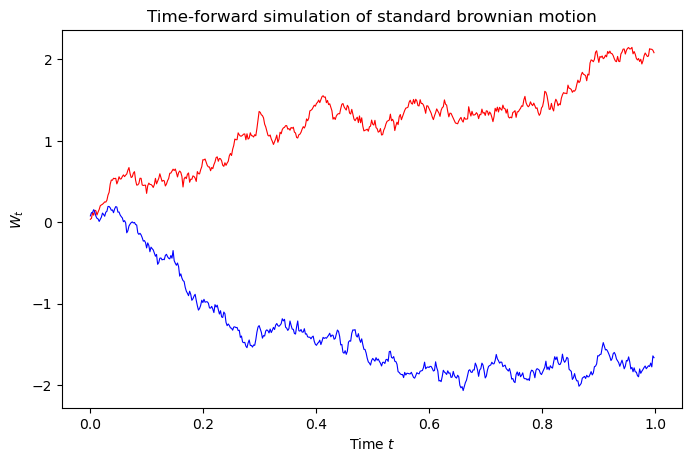

In [5]:
n = 9
plt.figure(figsize=(8,5), dpi=100)
tin = np.arange(0, T, 2**(-n))
samples = forward(n, T, (1000,))
print(samples.shape)
plt.plot(tin, samples[:,0], 'r-', linewidth=0.8)
plt.plot(tin, samples[:,1], 'b-', linewidth=0.8)
plt.xlabel("Time $t$")
plt.ylabel("$W_t$")
plt.title("Time-forward simulation of standard brownian motion")

In [6]:
samples.shape

(512, 1000)

In theory,
$$
\begin{aligned}
    \mathbb E[W_T] &= 0 \\
    \mathrm{Var}[W_T] &= T \\
    \mathrm{Cov}(W_T, W_{T/2}) &= \mathrm{Cov}(W_T-W_{T/2}+W_{T/2}, W_{T/2}) = \mathrm{Cov}(W_{T/2}, W_{T/2}) = T/2
\end{aligned}
$$

In [7]:
# Compute samples mean, variance for varying n
## Forward simulation
Nmin = 5
Nmax = 17
mu_vals = []
sigma_vals = []
cov_vals = []

for n in range(Nmin, Nmax):
    print("Time-step Resolution: %s" % 2**n)
    samples = forward(n, T, (1000,))

    mu = np.mean(samples[-1])
    mu_vals.append(mu)
    print("Mean: %s" % mu)

    sigma2 = np.var(samples[-1], ddof=1)
    sigma_vals.append(sigma2)
    print("Variance: %s" % sigma2)

    covar = np.cov(samples[-1], samples[2**(n-1)])
    cov_vals.append(covar[0,1])
    print("Covariance of (WT, WT/2): %s" % covar[0,1])
    print()


Time-step Resolution: 32
Mean: 0.08181481885408749
Variance: 1.0183247111174265
Covariance of (WT, WT/2): 0.5442620679375073

Time-step Resolution: 64
Mean: 0.004767606866673795
Variance: 0.981537364163078
Covariance of (WT, WT/2): 0.4818067214337092

Time-step Resolution: 128
Mean: -0.034666647939252795
Variance: 1.011147952580979
Covariance of (WT, WT/2): 0.5174915377568764

Time-step Resolution: 256
Mean: -0.024313080195519185
Variance: 0.9404220629327296
Covariance of (WT, WT/2): 0.47306294294867995

Time-step Resolution: 512
Mean: -0.004579715884487043
Variance: 0.9950928127916618
Covariance of (WT, WT/2): 0.5116646040889968

Time-step Resolution: 1024
Mean: 0.049765286220124286
Variance: 0.9730199130845897
Covariance of (WT, WT/2): 0.47801546887935537

Time-step Resolution: 2048
Mean: 0.057958360997298765
Variance: 0.9769458389124839
Covariance of (WT, WT/2): 0.48935396335364756

Time-step Resolution: 4096
Mean: -0.007369748810194352
Variance: 0.9100030905536854
Covariance of (WT

Text(0.5, 0, 'Log2-sample size $n$')

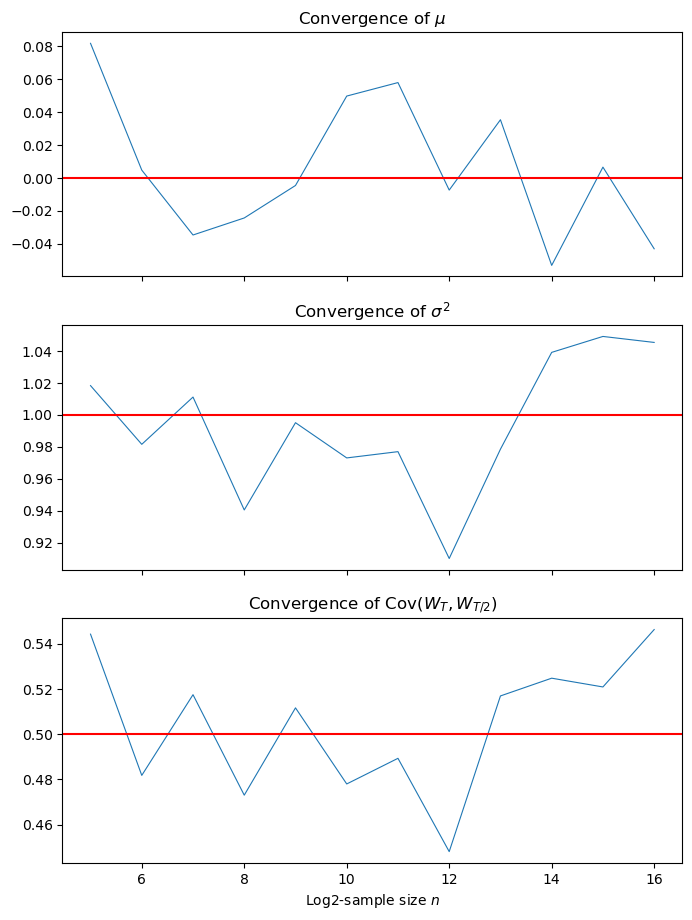

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8,11), dpi=100, sharex=True)

my_style = {
    'linewidth': 0.8
}

n_sizes = range(Nmin, Nmax)
axes[0].plot(n_sizes, mu_vals, **my_style)
axes[0].axhline(0, 0, T, color='r')
axes[0].set_title(r"Convergence of $\mu$")

axes[1].plot(n_sizes, sigma_vals, **my_style)
axes[1].axhline(T, 0, T, color='r')
axes[1].set_title(r"Convergence of $\sigma^2$")

axes[2].plot(n_sizes, cov_vals, **my_style)
axes[2].axhline(T/2, 0, T, color='r')
axes[2].set_title(r"Convergence of $\mathrm{Cov}(W_T, W_{T/2})$")
axes[2].set_xlabel("Log2-sample size $n$")

We see basically no enhancement by increasing the log-size $n$.

# Backward simulation

We compute the characteristic function of $W_{\bar s}\,|\, (W_{s_1}=x_1, W_{s_2}=x_2)$:
$$
\begin{aligned}
    \mathbb E\left[ e^{iuW_{\bar s}} \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right]
    &=
    e^{iu\bar x}\mathbb E\left[ \exp\left(iu \left(W_{\bar s}-\frac{W_{s_1} + W_{s_2}}{2}\right)\right) \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right]  \\
    &= e^{iu\bar x}\mathbb E\left[ e^{-iu(W_{\bar s} - W_{s_1})/2} e^{-iu(W_{\bar s}-W_{s_2})/2} \middle| W_{s_1}=x_1, W_{s_2}=x_2 \right] \\
    &= e^{iu\bar x} e^{-\frac 12u^2(\bar s - s_1)/4} e^{-\frac12u^2(s_2 - \bar s)/4} \ \text{(Independence of increments)} \\
    &= \exp\left(iu\bar x - \frac 12 u^2\frac{s_2 - s_1}4\right)
\end{aligned}
$$

Thus, the variable has conditional distribution $\mathcal N(\bar x, \frac{s_2-s_1}{4})$.

The same can be said of $W_{\bar s}\,|\, (W_{s_1}=x_1, W_{s_2}=x_2, (W_u)_{u\not\in[s_1,s_2]})$, as the same computation as above will work.

We can represent the computation with the following graph (the starting, red nodes are the "known" values, $W_0$ and $W_T \sim \mathcal N(0, T)$), drawn for $n = 4$.

In [9]:
def backward(n, T):
    res = np.zeros(2**n+1)
    dt = T*2**(-n)
    res[2**n] = np.random.normal(0, np.sqrt(T))
    """
    if debug:
        print("Index k goes from %d to %d" % (0, 2**n))
    """
    # Iterate through the "floors" of the graph.
    for k in range(1, n+1):
        p = n-k
        """
        if debug:
            print('Resolution p=%d' % p)
        """
        for i in range(2**(k-1)):
            s1 = i*2**(p+1)
            s2 = (i+1)*2**(p+1)
            ti = int((s1+s2)/2)
            """
            if debug:
                print("  i=%d" % i, end='')
                print('  time %d, extremities s1=%d and s2=%d' % (ti, s1, s2))
            """
            ws1 = res[s1]
            ws2 = res[s2]
            # Get the variance of the midpoint-time sample
            sig2 = (s2-s1)*dt/4
            res[ti] = np.random.normal((ws1+ws2)/2, np.sqrt(sig2))
    return res[1:]

Text(0.5, 1.0, 'Time-backward simulation of standard brownian motion')

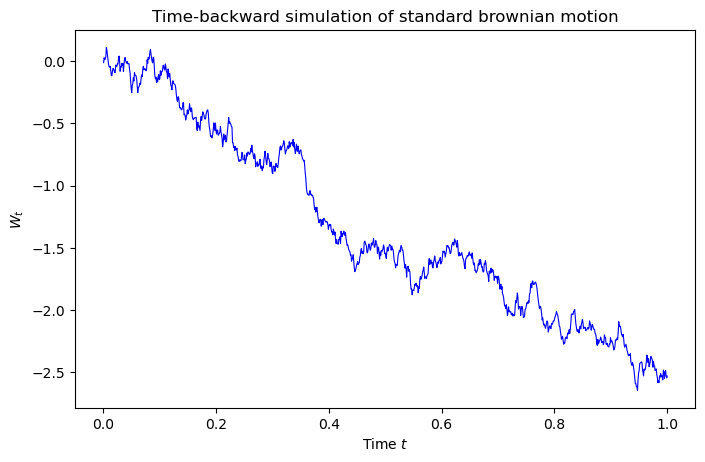

In [10]:
n = 10
Wt = backward(n, T)
plt.figure(figsize=(8,5), dpi=100)
tin = np.linspace(0, T, 2**n+1, endpoint=True)[1:]
plt.plot(tin, Wt, 'b-', linewidth=0.8)
plt.xlabel("Time $t$")
plt.ylabel("$W_t$")
plt.title("Time-backward simulation of standard brownian motion")

In [427]:
# Compute samples mean, variance for varying n
## Backward simulation
Nmin = 4
Nmax = 17
mu_vals = []
sigma_vals = []
cov_vals = []

print("BACKWARD SIMULATION ALGORITHM")
print("================")
for n in range(Nmin, Nmax):
    print("Time-step Resolution: %s" % 2**n)
    samples = [backward(n, T) for _ in range(1000)]
    samples = np.stack(samples).T

    mu = np.mean(samples[-1])
    mu_vals.append(mu)
    print("Mean: %s" % mu)

    sigma2 = np.var(samples[-1], ddof=1)
    sigma_vals.append(sigma2)
    print("Variance: %s" % sigma2)

    covar = np.cov(samples[-1], samples[2**(n-1)])
    cov_vals.append(covar[0,1])
    print("Covariance of (WT, WT/2): %s" % covar[0,1])
    print()


BACKWARD SIMULATION ALGORITHM
Time-step Resolution: 16
Mean: 0.004838724225798553
Variance: 1.005740696519114
Covariance of (WT, WT/2): 0.5494441005267131

Time-step Resolution: 32
Mean: -0.011195740636792408
Variance: 0.8990783351369981
Covariance of (WT, WT/2): 0.4828986146039649

Time-step Resolution: 64
Mean: -0.013565237375208209
Variance: 1.0130388816823657
Covariance of (WT, WT/2): 0.510008919609454

Time-step Resolution: 128
Mean: -0.0013848687857122074
Variance: 1.0174254436636823
Covariance of (WT, WT/2): 0.4928780300905397

Time-step Resolution: 256
Mean: -0.03356180954105533
Variance: 1.0639151207366413
Covariance of (WT, WT/2): 0.5414334345805564

Time-step Resolution: 512
Mean: -0.01051797183017209
Variance: 1.0235195732564897
Covariance of (WT, WT/2): 0.48270495251405343

Time-step Resolution: 1024
Mean: -0.05470753734925681
Variance: 1.0428512642418757
Covariance of (WT, WT/2): 0.5327023870749928

Time-step Resolution: 2048
Mean: -0.000624937907517519
Variance: 0.949184

Text(0.5,0,'Log2-sample size $n$')

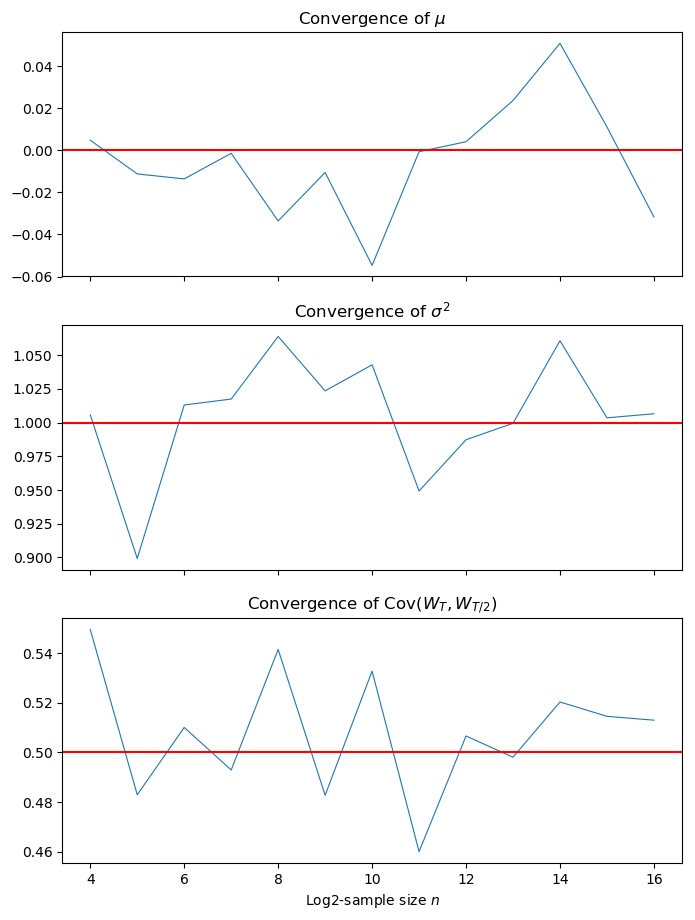

In [429]:
fig, axes = plt.subplots(3, 1, figsize=(8,11), dpi=100, sharex=True)

my_style = {
    'linewidth': 0.8
}

n_sizes = range(Nmin, Nmax)
axes[0].plot(n_sizes, mu_vals, **my_style)
axes[0].axhline(0, 0, T, color='r')
axes[0].set_title(r"Convergence of $\mu$")

axes[1].plot(n_sizes, sigma_vals, **my_style)
axes[1].axhline(T, 0, T, color='r')
axes[1].set_title(r"Convergence of $\sigma^2$")

axes[2].plot(n_sizes, cov_vals, **my_style)
axes[2].axhline(T/2, 0, T, color='r')
axes[2].set_title(r"Convergence of $\mathrm{Cov}(W_T, W_{T/2})$")
axes[2].set_xlabel("Log2-sample size $n$")

We don't see much improvement over the previous, forward-simulation algorithm.